In [2]:
#HIDDEN 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
#import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Bootstrapping for Linear Regression (Inference for the True Coefficients)

Recall that in linear regression, we create a model of the following form
$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} x_1 + \ldots + \hat{\theta_p} x_p
$$

We would like to infer the true coefficients of the model. Since the $\hat{\theta_0}$, $\hat{\theta_1}$, $\ldots$ $\hat{\theta_p}$ are estimators that vary based on our training data/observations, we would like to understand how our estimated coefficients compare with the true coefficients. Bootstrapping is a *nonparametric* approach to statistical inference that gives us standard errors and confidence intervals for our parameters. 

Let's take a look at an example of how we use bootstrapping methods within linear regression. 


### The Data

The Duncan dataset contains information on the prestige and other characteristics of 45 U. S. occupations in 1950. The data are in the the data frame Duncan in the `cars’ package. The variables are:

`prestige` represents the percentage of respondents in a survey who rated an occupation as “good” or “excellent” in prestige

`education` represents the percentage of incumbents in the occupation in the 1950 U.S. Census who were high school graduates

`income` represents the percentage of occupational incumbents who earned incomes in excess of $3,500.


In [3]:
duncan = pd.read_csv('duncan.csv').iloc[]
duncan

,Unnamed: 0,type,income,education,prestige
0,accountant,prof,62,86,82
1,pilot,prof,72,76,83
2,architect,prof,75,92,90
...,...,...,...,...,...
42,janitor,bc,7,20,8
43,policeman,bc,34,47,41
44,waiter,bc,8,32,10


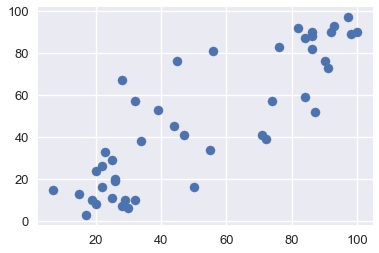

In [5]:
plt.scatter(x=duncan["education"], y=duncan["prestige"])

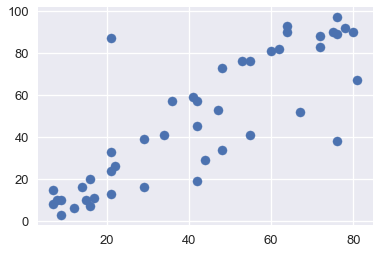

In [6]:
plt.scatter(x=duncan["income"], y=duncan["prestige"])

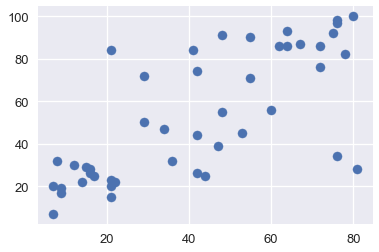

In [7]:
plt.scatter(x=duncan["income"], y=duncan["education"])

From the scatter plots above, we see that both income and education have a positive relationship with prestige. We would like to explore the partial relationship of prestige to education holding income constant (rather than the marginal relationship between prestige and education ignoring income).

### Fitting the model 

We will create the following model, that explains the prestige of an occupation as a linear function of income and education:

$$
\texttt{prestige}_i
= \beta_0^* 
+ \beta_\texttt{income}^*\cdot\texttt{income}_i
+ \beta_\texttt{education}^*\cdot\texttt{education}_i
+ \varepsilon_i
$$

Below, we fit our linear model and print all the $\beta$ coefficients of the model (from the equation above) after the model has been fit to the data.

In [11]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()
linear_model.fit(duncan.loc[:, ["income", "education"]], duncan["prestige"])

print("""
intercept: %.2f
income:    %.2f
education:    %.2f
""" % (tuple([linear_model.intercept_]) + tuple(linear_model.coef_)))


intercept: -6.06
income:    0.60
education:    0.55



The coefficients above give us an estimate of the true coefficients. But had our data been different, we would have fit our model to different data, causing these coefficients to be different. We would like to explore what our coefficients might have been using bootstrapping methods.

### Method 1: Bootstrapping the Observations 

Researchers are most interested in the coefficient of education.

#### Bootstrap Sampling Distribution of $\widehat\beta_\texttt{education}$

Here we consider the pairs $(X_i, y_i)$ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
(X_i^*, y_i^*) 
= (X_I, y_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
$$

In [16]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

In [23]:
def educ_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    
    linear_model = lm.LinearRegression()
    model = linear_model.fit(X, y)
    beta_educ = model.coef_[1]

    return beta_educ

data_array = duncan.loc[:, ["prestige", "income", "education"]].values

beta_hat_sampling = bootstrap(data_array, educ_coeff)

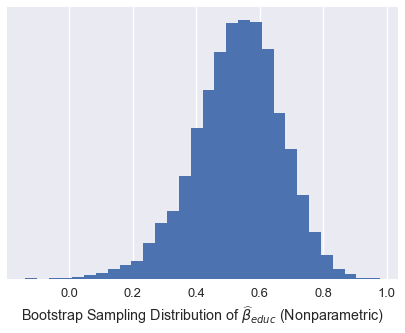

In [24]:
plt.figure(figsize = (7, 5))
plt.hist(beta_hat_sampling, bins = 30)
plt.xlabel("Bootstrap Sampling Distribution of $\\widehat{\\beta}_{educ}$ (Nonparametric)")
plt.yticks([])
plt.show()

#### Estimating the True Coefficients

Although we cannot directly measure $\beta_\texttt{education}$ we can use a bootstrap confidence interval to account for variability in the sample regression coefficient $\widehat\beta_{\texttt{education}}$. Below, We construct an approximate 95% confidence interval for the true coefficient $\widehat\beta_\texttt{education}$, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 5000 bootstrapped coefficients.

In [25]:
left_confidence_interval_endpoint = np.percentile(beta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(beta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(0.23605055884719855, 0.77537485790998895)

In order to build the sampling distribution of the coefficients and contruct the confidence intervals for the true coefficients, we directly resampling the observations z
i implicitly treats the regressors X1,... ,Xk as random
rather than fixed. We may want to treat the Xs as fixed (if, e.g., the data derive from an experimental
design). 

### Method 2: Bootstrapping the Residuals

1. Estimate the regression coefficients for the original sample, and calculate
the fitted value and residual for each observation.

2. Select bootstrap samples of the residuals and calculate bootstrapped Y values where the fitted values are obtained from the original regression.

3.  Regress the bootstrapped Y values on the fixed X values to obtain bootstrap regression
coefficients.

4. Repeat steps two and three several times in order to obtain several bootstrap regression coefficients. These can be used to compute bootstrap standard errors and confidence intervals. 

In [31]:
X = data_array[:, 1:]
y_hat = linear_model.predict(X)
y = duncan["prestige"]
residuals = (y - y_hat).values

def educ_coeff_semi(e, X = X, y_hat = y_hat):
    y_new = y_hat + e
    
    linear_model = lm.LinearRegression()
    model_new = linear_model.fit(X, y_new)
    return(model_new.coef_[1])

beta_hat_sampling_semi = bootstrap(residuals, educ_coeff_semi)

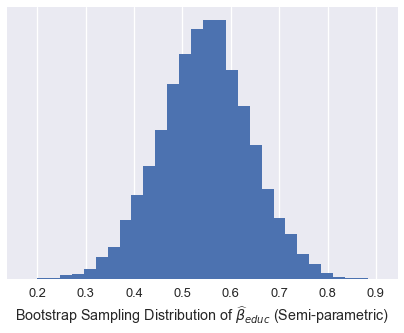

In [35]:
plt.figure(figsize = (7, 5))
plt.hist(beta_hat_sampling_semi, bins = 30)
plt.xlabel("Bootstrap Sampling Distribution of $\\widehat{\\beta}_{educ}$ (Semi-parametric)")
plt.yticks([])
plt.show()

### Estimating the True Coefficients

We can construct a confidence interval using the same technique as before.

In [34]:
left_confidence_interval_endpoint_semi = np.percentile(beta_hat_sampling_semi, 2.5)
right_confidence_interval_endpoint_semi = np.percentile(beta_hat_sampling_semi, 97.5)

left_confidence_interval_endpoint_semi, right_confidence_interval_endpoint_semi

(0.36043155555175738, 0.73017873381649079)

Let's reflect on this method. By randomly reattaching resampled residuals to ﬁtted values, this 
procedure implicitly assumes that the errors are identically distributed. This is a disadvantage to this model becathe true errors may have nonconstant variance

Although this method does not make any assumptions about the error distribution, it implicitly assumes that the functional form of the model is correct

### Summary